In [ ]:
import numpy as np
from scipy import signal
from keras.datasets import mnist
from keras.utils import np_utils

In [ ]:
#layer.py
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

In [ ]:
#dense.py
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [ ]:
#convolutional.py
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth): #depth=no. of kernals
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

In [ ]:
#reshape.py
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

In [ ]:
#activation.py
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [ ]:
#activations.py
class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.maximum(0,x)
        def relu_prime(x):
            return np.where(x>0,1,0)
        
        super().__init__(relu,relu_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        # This version is faster than the one presented in the video
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)
        # Original formula:
        # tmp = np.tile(self.output, n)
        # return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

class Linear(Activation):
    def __init__(self):
        def linear(x):
            return x

        def linear_prime(x):
            return 1 
        
        super().__init__(linear, linear_prime)

In [ ]:
#losses.py
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [ ]:
#netwwork.py
import matplotlib.pyplot as plt

def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    error_values = []
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        error_values.append(error)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")
    # Plot error over epochs
    plt.plot(error_values)
    plt.title('Error over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.show()


In [ ]:
# #preprocess data
# def preprocess_data(x, y, limit):
#     zero_index = np.where(y == 0)[0][:limit]
#     one_index = np.where(y == 1)[0][:limit]
#     all_indices = np.hstack((zero_index, one_index))
#     all_indices = np.random.permutation(all_indices)
#     x, y = x[all_indices], y[all_indices]
#     x = x.reshape(len(x), 1, 28, 28)
#     x = x.astype("float32") / 255
#     y = np_utils.to_categorical(y)
#     y = y.reshape(len(y), 2, 1)
#     return x, y

#preprocess data
def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    two_index = np.where(y == 2)[0][:limit]
    three_index = np.where(y == 3)[0][:limit]
    four_index = np.where(y == 4)[0][:limit]
    five_index = np.where(y == 5)[0][:limit]
    six_index = np.where(y == 6)[0][:limit]
    seven_index = np.where(y == 7)[0][:limit]
    eight_index = np.where(y == 8)[0][:limit]
    nine_index = np.where(y == 9)[0][:limit]
    all_indices = np.hstack((zero_index, one_index,two_index,three_index,four_index,five_index,six_index,seven_index,eight_index,nine_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y),10, 1)
    return x, y



11490434/11490434 [==============================] - 0s 0us/step
1/20, error=0.3785552877538527
2/20, error=0.059940846393234264
3/20, error=0.03293187822059621
4/20, error=0.026946939272031872
5/20, error=0.019825087682580497
6/20, error=0.012599442925586428
7/20, error=0.008656699748081418
8/20, error=0.007468726162902887
9/20, error=0.006822866355695241
10/20, error=0.00566506674479925
11/20, error=0.004595564560546903
12/20, error=0.0040231374798675714
13/20, error=0.0037226569964925044
14/20, error=0.003475124821660509
15/20, error=0.0032453690291036246
16/20, error=0.0030117183299650198
17/20, error=0.0027367238558163726
18/20, error=0.002468399906510416
19/20, error=0.0023259595068502153
20/20, error=0.0022159505639775777


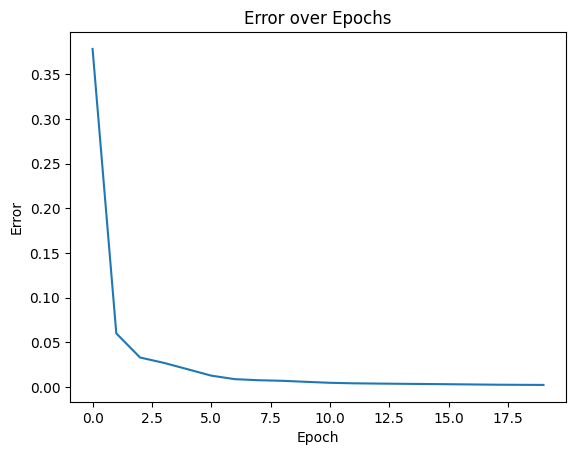

In [ ]:
# driver code1 for mnist binary classification using convolutional
# neural netwwwork
# load MNIST from server, limit to 100 images per class since we're not training on GPU
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Sigmoid()
]

# train
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=20,
    learning_rate=0.1
)

In [ ]:
correct=0
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")
    if np.argmax(output)==np.argmax(y):
        correct=correct+1
accuracy=correct/len(y_test)
print("accuracy: ",accuracy*100)
print("correct: ",correct)

pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true:

1/20, error=0.32758439017287627
2/20, error=0.27964338030527686
3/20, error=0.2684952313920971
4/20, error=0.26159304628775215
5/20, error=0.25921739886760237
6/20, error=0.258075277711845
7/20, error=0.2568646633068769
8/20, error=0.2554665638015134
9/20, error=0.25458916398813863
10/20, error=0.2542272818062341
11/20, error=0.2539119790209272
12/20, error=0.25369693678647753
13/20, error=0.2535435158949424
14/20, error=0.2534070193929288
15/20, error=0.25328159156804503
16/20, error=0.2531762372980781
17/20, error=0.253082013853177
18/20, error=0.25298642935467375
19/20, error=0.25287228994646155
20/20, error=0.2526953565226598


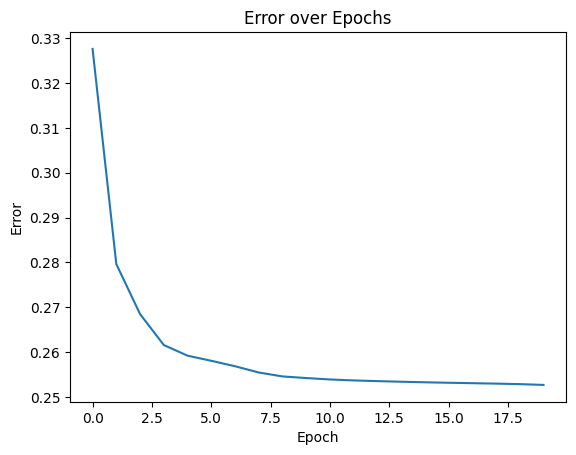

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Sigmoid(),
]

# train
train(
    network,
    mse,
    mse_prime,
    x_train,
    y_train,
    epochs=20,
    learning_rate=0.1
)

In [ ]:
correct=0
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")
    if np.argmax(output)==np.argmax(y):
        correct=correct+1
accuracy=correct/len(y_test)
print("accuracy: ",accuracy*100)
print("correct: ",correct)

pred: 0, true: 1
pred: 0, true: 1
pred: 0, true: 1
pred: 0, true: 1
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 1
pred: 0, true: 1
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true:

1/20, error=0.5752884612489193
2/20, error=0.49999999632682235
3/20, error=0.4999999963263294
4/20, error=0.4999999963258365
5/20, error=0.49999999632534303
6/20, error=0.4999999963248493
7/20, error=0.49999999632435527
8/20, error=0.499999996323861
9/20, error=0.4999999963233666
10/20, error=0.49999999632287184
11/20, error=0.4999999963223764
12/20, error=0.4999999963218811
13/20, error=0.4999999963213853
14/20, error=0.4999999963208894
15/20, error=0.49999999632039277
16/20, error=0.49999999631989617
17/20, error=0.4999999963193991
18/20, error=0.49999999631890174
19/20, error=0.49999999631840425
20/20, error=0.4999999963179064


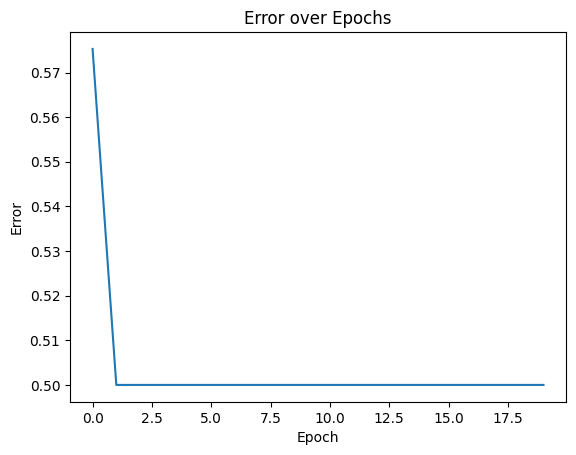

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),
    Tanh(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Tanh(),
    Dense(100, 2),
    Tanh(),
]

# train
train(
    network,
    mse,
    mse_prime,
    x_train,
    y_train,
    epochs=20,
    learning_rate=0.1
)

In [ ]:
correct=0
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")
    if np.argmax(output)==np.argmax(y):
        correct=correct+1
accuracy=correct/len(y_test)
print("accuracy: ",accuracy*100)
print("correct: ",correct)

pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 0
pred: 1, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 0
pred: 1, true: 1
pred: 1, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 0
pred: 1, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 0
pred: 1, true: 0
pred: 1, true: 0
pred: 1, true: 0
pred: 1, true: 1
pred: 1, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 0
pred: 1, true: 1
pred: 1, true:

1/20, error=0.17898794025823275
2/20, error=0.03346824241137092
3/20, error=0.019176790242505782
4/20, error=0.008852636107774833
5/20, error=0.004590246085245879
6/20, error=0.004191740955777928
7/20, error=0.0006887049111285094
8/20, error=0.00034210990784482704
9/20, error=0.0002930132427541026
10/20, error=0.0002348089089927949
11/20, error=0.0001995001007165885
12/20, error=0.00018774569175321703
13/20, error=0.00017691334875951867
14/20, error=0.0001667072580824687
15/20, error=0.00015667258783543295
16/20, error=0.00014601133095381162
17/20, error=0.00013414637811099363
18/20, error=0.00012307451138836078
19/20, error=0.00011545024521128508
20/20, error=0.00011006807157859536


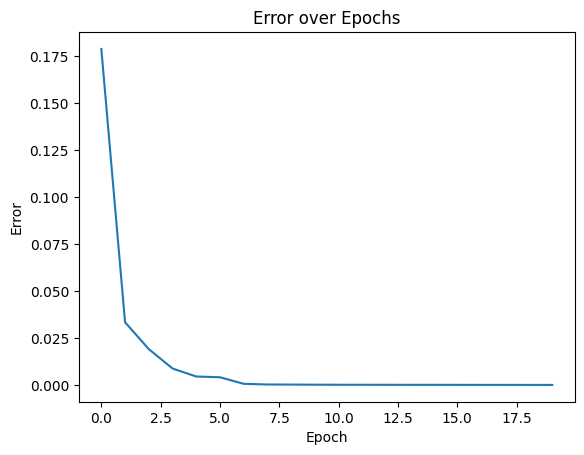

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),
    ReLU(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Softmax(),
]

# train
train(
    network,
    mse,
    mse_prime,
    x_train,
    y_train,
    epochs=20,
    learning_rate=0.1
)

In [ ]:
correct=0
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")
    if np.argmax(output)==np.argmax(y):
        correct=correct+1
accuracy=correct/len(y_test)
print("accuracy: ",accuracy*100)
print("correct: ",correct)

pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true:

<ipython-input-19-9e621e0d8388>:24: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


1/20, error=0.5395038403889509
2/20, error=0.03646806040565966
3/20, error=0.029090513375547185
4/20, error=0.0045028514275414835
5/20, error=0.0020647026389301573
6/20, error=0.001575092926011101
7/20, error=0.00122022451508355
8/20, error=0.0010463154915307596
9/20, error=0.0009680078654665137
10/20, error=0.0009044122263886877
11/20, error=0.0008463198781600195
12/20, error=0.0007873685859585103
13/20, error=0.0006969897608609193
14/20, error=0.0005877351399205433
15/20, error=0.0005681613700030783
16/20, error=0.0005479038654791112
17/20, error=0.0005282326652626948
18/20, error=0.0005099573018698413
19/20, error=0.0004931033446471385
20/20, error=0.0004770472343816671


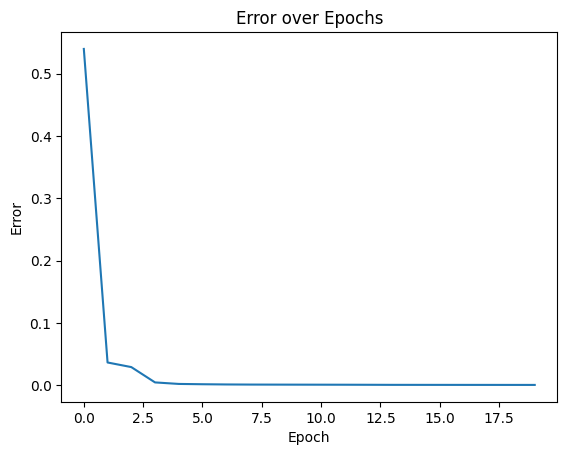

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),
    ReLU(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Softmax(),
]

# train
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=20,
    learning_rate=0.1
)

In [ ]:
correct=0
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")
    if np.argmax(output)==np.argmax(y):
        correct=correct+1
accuracy=correct/len(y_test)
print("accuracy: ",accuracy*100)
print("correct: ",correct)

pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true:

<ipython-input-19-9e621e0d8388>:24: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))



pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
accuracy:  99.5
correct:  199


1/20, error=0.3684233942380063
2/20, error=0.2905891513874091
3/20, error=0.264862164399411
4/20, error=0.2297793050126955
5/20, error=0.2050437305403702
6/20, error=0.18548960191879665
7/20, error=0.17341378963378185
8/20, error=0.1620728669434239
9/20, error=0.14837200958225114
10/20, error=0.1427246175071407
11/20, error=0.13068596375335817
12/20, error=0.1266842675567269
13/20, error=0.12441360275732485
14/20, error=0.11094473967286014
15/20, error=0.10513927391678773
16/20, error=0.1035429992969986
17/20, error=0.09771427292426964
18/20, error=0.09523114696169602
19/20, error=0.08778367109499778
20/20, error=0.08155310436154485


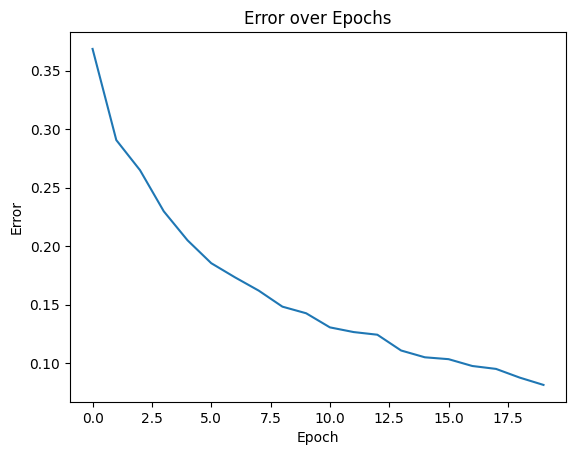

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 10),
    Softmax()
]

# train
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=20,
    learning_rate=0.1
)

In [ ]:
correct=0
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")
    if np.argmax(output)==np.argmax(y):
        correct=correct+1
accuracy=correct/len(y_test)
print("accuracy: ",accuracy*100)
print("correct: ",correct)

pred: 6, true: 6
pred: 2, true: 4
pred: 9, true: 4
pred: 2, true: 8
pred: 5, true: 5
pred: 9, true: 9
pred: 4, true: 4
pred: 1, true: 1
pred: 0, true: 0
pred: 2, true: 2
pred: 2, true: 2
pred: 6, true: 4
pred: 6, true: 6
pred: 6, true: 6
pred: 8, true: 5
pred: 0, true: 0
pred: 9, true: 9
pred: 5, true: 3
pred: 6, true: 6
pred: 2, true: 2
pred: 9, true: 9
pred: 7, true: 7
pred: 2, true: 2
pred: 4, true: 4
pred: 9, true: 9
pred: 0, true: 0
pred: 4, true: 4
pred: 7, true: 7
pred: 8, true: 8
pred: 0, true: 0
pred: 4, true: 6
pred: 1, true: 1
pred: 9, true: 9
pred: 4, true: 2
pred: 1, true: 1
pred: 8, true: 8
pred: 6, true: 6
pred: 0, true: 0
pred: 4, true: 0
pred: 3, true: 3
pred: 7, true: 7
pred: 2, true: 2
pred: 6, true: 6
pred: 5, true: 5
pred: 4, true: 6
pred: 8, true: 8
pred: 1, true: 1
pred: 3, true: 3
pred: 6, true: 6
pred: 4, true: 4
pred: 7, true: 7
pred: 2, true: 9
pred: 9, true: 9
pred: 7, true: 7
pred: 5, true: 5
pred: 3, true: 3
pred: 9, true: 9
pred: 6, true: 6
pred: 9, true:

1/20, error=0.21624643248986058
2/20, error=0.1358484998981517
3/20, error=0.11591355581598575
4/20, error=0.10427920166064
5/20, error=0.0923565196336003
6/20, error=0.08577613619630874
7/20, error=0.08202485199267547
8/20, error=0.07767139433232127
9/20, error=0.07584364888929104
10/20, error=0.07633192540096738
11/20, error=0.06965759597215002
12/20, error=0.07080389474550976
13/20, error=0.06944391494669466
14/20, error=0.06530746475136931
15/20, error=0.06126033554485243
16/20, error=0.060918996079843996
17/20, error=0.06039591989660675
18/20, error=0.05756558360829213
19/20, error=0.058139257299287955
20/20, error=0.05745743482164554


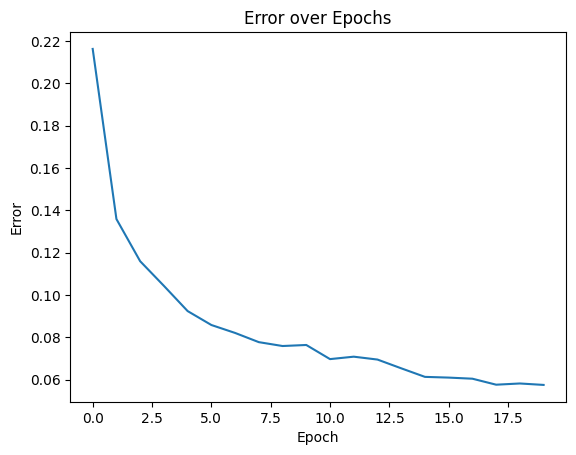

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 2000)
x_test, y_test = preprocess_data(x_test, y_test, 100)

# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 10),
    Softmax()
]

# train
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=20,
    learning_rate=0.1
)

In [ ]:
correct=0
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")
    if np.argmax(output)==np.argmax(y):
        correct=correct+1
accuracy=correct/len(y_test)
print("accuracy: ",accuracy*100)
print("correct: ",correct)

pred: 9, true: 9
pred: 3, true: 3
pred: 6, true: 6
pred: 8, true: 8
pred: 7, true: 7
pred: 7, true: 7
pred: 3, true: 8
pred: 8, true: 8
pred: 8, true: 8
pred: 9, true: 9
pred: 5, true: 5
pred: 4, true: 4
pred: 4, true: 6
pred: 8, true: 8
pred: 7, true: 2
pred: 0, true: 0
pred: 4, true: 4
pred: 1, true: 9
pred: 5, true: 5
pred: 8, true: 8
pred: 9, true: 9
pred: 1, true: 1
pred: 6, true: 6
pred: 2, true: 2
pred: 1, true: 1
pred: 2, true: 8
pred: 9, true: 9
pred: 6, true: 6
pred: 9, true: 8
pred: 1, true: 1
pred: 2, true: 2
pred: 1, true: 1
pred: 6, true: 6
pred: 4, true: 4
pred: 2, true: 2
pred: 0, true: 0
pred: 2, true: 2
pred: 8, true: 8
pred: 1, true: 1
pred: 2, true: 2
pred: 5, true: 5
pred: 2, true: 2
pred: 9, true: 9
pred: 8, true: 8
pred: 8, true: 8
pred: 7, true: 7
pred: 7, true: 7
pred: 2, true: 2
pred: 4, true: 8
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 9, true: 9
pred: 6, true: 6
pred: 0, true: 2
pred: 9, true: 4
pred: 1, true: 1
pred: 0, true: 0
pred: 3, true:

1/40, error=0.35500964884860986
2/40, error=0.3056489569783147
3/40, error=0.2800330490446375
4/40, error=0.2551745222524572
5/40, error=0.2341478546829537
6/40, error=0.22068114545520315
7/40, error=0.20797508972325793
8/40, error=0.19570100998161985
9/40, error=0.18058617869589094
10/40, error=0.1764201537694106
11/40, error=0.17131623616449124
12/40, error=0.1616233392610449
13/40, error=0.1498739874599336
14/40, error=0.146533000037216
15/40, error=0.14010458277095408
16/40, error=0.13777140922495953
17/40, error=0.13392043169508744
18/40, error=0.12344806550075815
19/40, error=0.13254849155248596
20/40, error=0.11911408739815205
21/40, error=0.11322732460694483
22/40, error=0.1064461681758576
23/40, error=0.1032888443732334
24/40, error=0.1009889770982622
25/40, error=0.09741590133949225
26/40, error=0.08945823603153277
27/40, error=0.08722767420609412
28/40, error=0.08433525527403361
29/40, error=0.08574865200588287
30/40, error=0.08249416509399156
31/40, error=0.0855172247969510

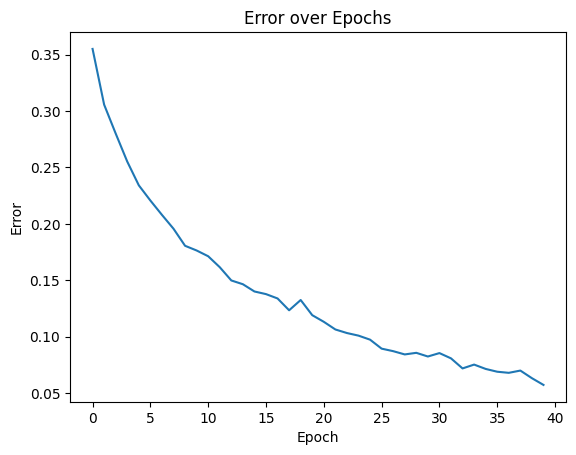

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 10),
    Softmax()
]

# train
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=40,
    learning_rate=0.1
)

In [ ]:
correct=0
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")
    if np.argmax(output)==np.argmax(y):
        correct=correct+1
accuracy=correct/len(y_test)
print("accuracy: ",accuracy*100)
print("correct: ",correct)

pred: 5, true: 5
pred: 1, true: 1
pred: 2, true: 2
pred: 1, true: 1
pred: 9, true: 6
pred: 5, true: 6
pred: 9, true: 4
pred: 0, true: 0
pred: 2, true: 2
pred: 5, true: 5
pred: 8, true: 8
pred: 8, true: 2
pred: 5, true: 5
pred: 6, true: 6
pred: 4, true: 4
pred: 2, true: 8
pred: 8, true: 8
pred: 5, true: 8
pred: 8, true: 8
pred: 5, true: 5
pred: 7, true: 7
pred: 9, true: 2
pred: 5, true: 5
pred: 3, true: 3
pred: 6, true: 2
pred: 6, true: 6
pred: 9, true: 9
pred: 7, true: 7
pred: 3, true: 3
pred: 6, true: 6
pred: 2, true: 2
pred: 7, true: 7
pred: 4, true: 6
pred: 5, true: 5
pred: 4, true: 4
pred: 7, true: 3
pred: 2, true: 2
pred: 0, true: 0
pred: 4, true: 4
pred: 6, true: 6
pred: 1, true: 1
pred: 2, true: 8
pred: 0, true: 0
pred: 3, true: 3
pred: 3, true: 3
pred: 9, true: 9
pred: 5, true: 1
pred: 8, true: 8
pred: 1, true: 1
pred: 3, true: 3
pred: 6, true: 6
pred: 5, true: 5
pred: 7, true: 7
pred: 9, true: 9
pred: 5, true: 5
pred: 6, true: 6
pred: 9, true: 9
pred: 2, true: 2
pred: 9, true: